# Exercise: MedMCQA Dataset

*MedMCQA dataset description*

MedMCQA is a large-scale, Multiple-Choice Question Answering (MCQA) dataset designed to address real-world medical entrance exam questions.

MedMCQA has more than 194k high-quality AIIMS & NEET PG entrance exam MCQs covering 2.4k healthcare topics and 21 medical subjects are collected with an average token length of 12.77 and high topical diversity.

Each sample contains a question, correct answer(s), and other options which require a deeper language understanding as it tests the 10+ reasoning abilities of a model across a wide range of medical subjects, including the followings:
Anesthesia, Anatomy, Biochemistry, Dental, ENT, Forensic Medicine (FM), Obstetrics and Gynecology (O&G), Medicine, Microbiology, Ophthalmology, Orthopedics, Pathology, Pediatrics, Pharmacology, Physiology, Psychiatry, Radiology, Skin, Preventive & Social Medicine (PSM), Surgery.

More information in Reference: https://huggingface.co/datasets/openlifescienceai/medmcqa

*Exercise Description*

**Objective**: Compare the performance of two large language models (LLMs) in answering questions from the MedMCQA dataset, based on the following guidelines.

- **Models for Comparison**: The models being evaluated are GPT-4.1 and GPT-4O.

- **Subjects to Include**: Focus on questions related to the following subjects: Dental, Pathology, Surgery, Medicine, Anaesthesia, and Radiology.

- **Evaluation Metrics**:
1. Compare the overall accuracy of both models.
2. Compare the accuracy of each model by subject.

- **Scope**: The comparison is limited to the validation dataset.

# Imports

In [1]:
import os
from openai import AzureOpenAI
import pprint
import tqdm
from datasets import load_dataset
import time
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import json
# import seaborn as sns

c:\Users\Nidia Bucarelli\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting Started: Azure AI

In [2]:
# Build your client
client = AzureOpenAI(azure_endpoint = "https://azure-ai.hms.edu", # http://azure-ai.hms.edu
  api_key=  "ce761dd8c5784b6292645116e73ac921",  ##os.getenv("AZURE_OPENAI_API_KEY"), 
  api_version="2024-10-21")

In [3]:
#  Prompt/User input
query = 'Tell me a joke'
message = [
  {"role": "system", "content": "You are a helpful AI assistant."}, 
  {"role": "user", "content": f"{query}"}
]

In [4]:
## Submit your request
response = client.chat.completions.create(
  model='gpt-4o-1120', # Model deployment id
  messages = message,        
  temperature=0.5, ## to control creativity
  max_tokens=250)
print(response.choices[0].message.content)

Sure! Here's one:

Why don’t skeletons fight each other?  
Because they don’t have the guts!


# Data Loading and Preprocessing

In [24]:
## Load dataset
# https://huggingface.co/datasets/openlifescienceai/medmcqa
# Login using e.g. `huggingface-cli login` to access this dataset

data= load_dataset("openlifescienceai/medmcqa")

## to preview the data
data


DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

In [25]:
## Convert validation dataset to dataframe
data = data['validation'].to_pandas()
data.head()

## print data shape
pprint.pprint(data.shape)


(4183, 11)


In [26]:

## show questions types
pprint.pprint(data['choice_type'].value_counts())


## show count of subjects
pprint.pprint(data['subject_name'].value_counts())


## Filter the dataset by:
# Single questions
data = data[data.choice_type =='single']


# Subject_names : [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology']
subject_names = [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology']
data = data[data.subject_name.isin(subject_names)]


# Show final data shape
data.reset_index(inplace=True, drop=True)
data.shape
pprint.pprint(data.shape)


choice_type
single    2816
multi     1367
Name: count, dtype: int64
subject_name
Dental                          1318
Surgery                          369
Pathology                        337
Medicine                         295
Pharmacology                     243
Pediatrics                       234
Anatomy                          234
Gynaecology & Obstetrics         224
Physiology                       171
Biochemistry                     171
Social & Preventive Medicine     129
Microbiology                     122
Radiology                         69
Forensic Medicine                 67
Ophthalmology                     58
ENT                               53
Anaesthesia                       34
Orthopaedics                      20
Skin                              17
Psychiatry                        16
Unknown                            2
Name: count, dtype: int64
(1619, 11)


# Inference

In [ ]:
## Helper functions to prapare data for inference

def generate_message(query):

    """
    Constructs a message for an AI assistant to answer a medical multiple-choice question.

    The function returns a list of messages formatted for use with chat-based language models
    (e.g., OpenAI's GPT API), setting the assistant's role and providing context with an example.

    The assistant is instructed to act as a medical doctor and select the correct answer from 
    the given choices (A to D) without explanation.

    Parameters:
        query (str): The medical multiple-choice question formatted with options.

    Returns:
        list: A list of dictionaries representing the chat message history. It includes:
            - A system message with detailed instructions and an example format.
            - A user message containing the input query.
    """
    instruction = '''You are a medical doctor answering real-world medical entrance exam questions. Based on your understanding of basic and clinical science, medical knowledge, and mechanisms underlying health, disease, patient care, and modes of therapy, answer the following multiple-choice question. Select one correct answer from A to D. Do not provide reasons. Only the letter of the correct answer. Follow the example below.'''

    example = '''Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma:
    (A) Hyperplasia
    (B) Hyperophy
    (C) Atrophy
    (D) Dyplasia
    Answer: C'''


    message = [
    {"role": "system", "content": f"You are a helpful AI assistant. {instruction} \n\n Example:\n\n{example}"}, 
    {"role": "user", "content": f"{query}"}
    ]
    return message

def create_query(x):

    """
    Formats a dictionary containing a medical question and answer choices into a structured prompt.

    The function accepts a dictionary with a question and four options, and returns a string 
    formatted as a multiple-choice question, suitable for passing to a language model.

    Parameters:
        x (dict): A dictionary with the following keys:
            - 'question' (str): The question text.
            - 'opa' (str): Option A.
            - 'opb' (str): Option B.
            - 'opc' (str): Option C.
            - 'opd' (str): Option D.

    Returns:
        str: A formatted multiple-choice question string with options labeled (A) to (D).
    """

    question = x['question']
    option_A = x['opa']
    option_B = x['opb']
    option_C = x['opc']
    option_D =  x['opd']
    prompt = f'''Question: {question}
    (A) {option_A}
    (B) {option_B}
    (C) {option_C}
    (D) {option_D}
    '''
    
    return prompt

##  Example (1 sample)


In [9]:

## Step 1. Create query
example = data.iloc[0] ## first sample/row/question
query = create_query(example)
## show the query
pprint.pprint(query)

## Step 2. Generate message
message  = generate_message(query)
## show the message
pprint.pprint(message)


## Step 3. Submit request
response = client.chat.completions.create(
  model='gpt-4o-1120', # Model deployment id
  messages = message,        
  temperature=0, ## <---Model should always pick the single most probable next token (i.e. greedy decoding)
  max_tokens=250)

## show the model answer

pprint.pprint(response.choices[0].message.content)

('Question: A 29 yrs old woman with a pregnancy of 17 week has a 10 years old '
 'boy with down syndrome. She does not want another down syndrome kid; best '
 'advice to her is\n'
 '    (A) No test is required now as her age is below 35 years\n'
 '    (B) Ultra sound at this point of time will definitely tell her that next '
 'baby will be down syndromic or not\n'
 '    (C) Amniotic fluid samples plus chromosomal analysis will definitely '
 'tell her that next baby will be down syndromic or not\n'
 '    (D) blood screening at this point of time will clear the exact picture\n'
 '    ')
[{'content': 'You are a helpful AI assistant. You are a medical doctor '
             'answering real-world medical entrance exam questions. Based on '
             'your understanding of basic and clinical science, medical '
             'knowledge, and mechanisms underlying health, disease, patient '
             'care, and modes of therapy, answer the following multiple-choice '
             'question.

## Full Dataset

In [10]:
## Step 1. Create queries
data['query'] = data.apply(create_query,axis=1)


## Step 2. Generate messages
queries = data['query'].values
messages = [generate_message(query) for query in queries]


## Step 3. Submit requests and save results
model_ids = ["gpt-4o-1120","gpt-4.1"]
model_responses = {} ## to save model outputs
for model_id in model_ids:
    print (f'generating inference using {model_id}...')
    responses= {} 
    start_time = time.time()
    for message, id_ in tqdm.tqdm(zip(messages, data['id'].values),total=len(messages),desc="Processing messages"):
            try:
                    response = client.chat.completions.create(
                    model=model_id, # Model deployment id
                    messages = message,        
                    temperature=0,
                    max_tokens=250)
                    
                    answer = response.choices[0].message.content

                    responses[id_] = answer
            except Exception as e: 
                    print(f"❌ Message {id_} failed: {e}")
                    answer = "Filtered or failed"
                    responses[id_] = answer
                

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Execution time: {end_time - start_time:.4f} seconds")
    model_responses[model_id] = responses
    

generating inference using gpt-4o-1120...


Processing messages:   5%|▍         | 80/1619 [00:34<08:12,  3.12it/s]

❌ Message 62081a5c-5ffc-4a88-9aca-c9e430490e73 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:   9%|▉         | 147/1619 [01:00<07:33,  3.25it/s]

❌ Message 700fb2a4-66cc-4d8e-890d-c8d0840b287f failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  20%|██        | 329/1619 [02:07<06:03,  3.55it/s]

❌ Message b7507844-7679-49f9-a915-6a242af404d9 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  29%|██▊       | 462/1619 [02:57<06:43,  2.87it/s]

❌ Message 137a6893-800d-4ef6-a9b9-8e55a19b5476 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  80%|███████▉  | 1294/1619 [08:18<01:40,  3.24it/s]

❌ Message 3aed5296-d2c0-4347-8804-d85234302675 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Processing messages:  90%|█████████ | 1462/1619 [09:17<00:46,  3.41it/s]

❌ Message abca2f84-074e-46e8-9932-d9123850b023 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages: 100%|██████████| 1619/1619 [10:16<00:00,  2.63it/s]


Execution time: 616.2613 seconds
generating inference using gpt-4.1...


Processing messages:   5%|▍         | 80/1619 [00:29<08:35,  2.99it/s]

❌ Message 62081a5c-5ffc-4a88-9aca-c9e430490e73 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:   9%|▉         | 147/1619 [00:56<08:44,  2.81it/s]

❌ Message 700fb2a4-66cc-4d8e-890d-c8d0840b287f failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  20%|██        | 329/1619 [02:05<09:33,  2.25it/s]

❌ Message b7507844-7679-49f9-a915-6a242af404d9 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  29%|██▊       | 462/1619 [02:56<05:58,  3.22it/s]

❌ Message 137a6893-800d-4ef6-a9b9-8e55a19b5476 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages:  80%|███████▉  | 1294/1619 [08:27<01:46,  3.06it/s]

❌ Message 3aed5296-d2c0-4347-8804-d85234302675 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


Processing messages:  90%|█████████ | 1462/1619 [09:30<00:49,  3.18it/s]

❌ Message abca2f84-074e-46e8-9932-d9123850b023 failed: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}


Processing messages: 100%|██████████| 1619/1619 [10:28<00:00,  2.58it/s]

Execution time: 628.3323 seconds


**Note**  
We are encountering these errors because certain questions are being blocked by Azure OpenAI's content filtering policies, specifically under the "violence" category of their Responsible AI filters.

For instance, the question "A female with suspected child abuse was brought to the casualty with severe bleeding from the perineum. What should be the first line of management?" was flagged by the system. This is likely due to two factors: a) It references suspected child abuse, and b) It describes severe bleeding from the perineum, which may imply physical violence or sexual trauma.

These topics fall into highly sensitive and regulated content areas (particularly when involving minors, violence, or sexual harm) and are therefore subject to automated filtering.

In [ ]:
# optional
# Save data to a JSON file
with open("azure-demo-LLMresponses.json", "w") as json_file:
    json.dump(model_responses, json_file, indent=4) 

# Response Processing

In [12]:
# Response processing

# Parse the model answer.
def extract_answer(x):
    x = x.lower()
    x = x.replace('answer:', '')
    return x.strip()

for model_id in model_ids:
    parsed_answers = {} 
    responses = model_responses[model_id]
    for id_ in responses:
        parsed_answers[id_] =extract_answer(responses[id_])
    data[f'pred_{model_id}'] = data['id'].map(parsed_answers)




## Performance Evaluation

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1619 non-null   object
 1   question          1619 non-null   object
 2   opa               1619 non-null   object
 3   opb               1619 non-null   object
 4   opc               1619 non-null   object
 5   opd               1619 non-null   object
 6   cop               1619 non-null   int64 
 7   choice_type       1619 non-null   object
 8   exp               529 non-null    object
 9   subject_name      1619 non-null   object
 10  topic_name        99 non-null     object
 11  query             1619 non-null   object
 12  pred_gpt-4o-1120  1619 non-null   object
 13  pred_gpt-4.1      1619 non-null   object
dtypes: int64(1), object(13)
memory usage: 177.2+ KB


In [ ]:
## overall accuracy
def  compute_accuracy(y_pred, y_true):
    count=0
    for y, yi in zip(y_pred, y_true):
        if y==yi:
            count +=1
    return count/len(y_true)
## map prediction to 0,1,2,4
labels2ids_dict= {'a': int(0), 'b': int(1), 'c': int(2), 'd': int(3)}
for model_id in model_ids:    
    data[f'pred_{model_id}'] = data[f'pred_{model_id}'].map(labels2ids_dict)

for model_id in model_ids:
    y_true = data['cop']
    y_pred = data[f'pred_{model_id}'] 

    overall_accuracy = compute_accuracy(y_pred, y_true)
    print (f'Overall accuracy of {model_id}: {overall_accuracy}')

Overall accuracy of gpt-4o-1120: 0.7498455836936381
Overall accuracy of gpt-4.1: 0.7578752316244596


In [15]:
## Field Accuracy

subject_names = [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology'] #solution_df['subject_name'].unique()
subject_accuracyModels= {} ## to store the accuracies
for model_id in model_ids:
    subject_accuracy = {}
    for subject in subject_names:
        X = data[data['subject_name']== subject]
        y_true = X['cop']
        y_pred = X[f'pred_{model_id}']

        accuracy =  compute_accuracy(y_true, y_pred)
        subject_accuracy[subject] = accuracy
    subject_accuracyModels[model_id] = subject_accuracy

df_subjectAccuracies = pd.DataFrame( {model_ids[0]: subject_accuracyModels[model_ids[0]] , 
                                      model_ids[1]: subject_accuracyModels[model_ids[1]]})
df_subjectAccuracies['Subject'] = df_subjectAccuracies.index

In [ ]:
## show performance
df_subjectAccuracies

,gpt-4o-1120,gpt-4.1,Subject
Dental,0.693491,0.702959,Dental
Pathology,0.884170,0.891892,Pathology
Surgery,0.730924,0.742972,Surgery
Medicine,0.810811,0.827027,Medicine
Anaesthesia,0.708333,0.708333,Anaesthesia
Radiology,0.877193,0.824561,Radiology


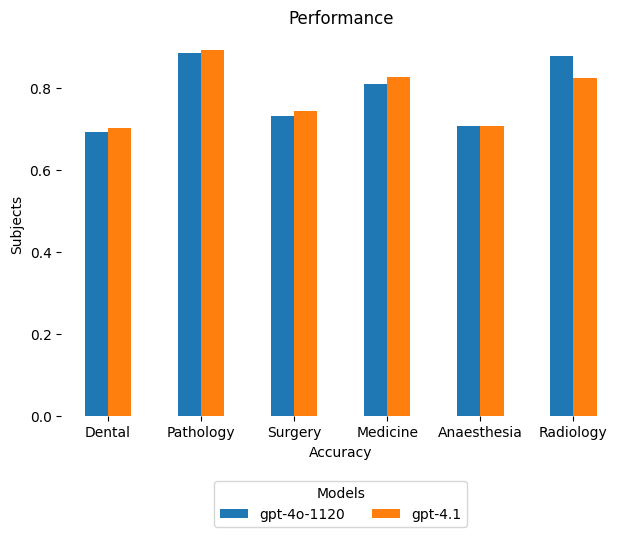

In [29]:
# Plot bar chart
ax = df_subjectAccuracies.plot(kind='bar')  # each column is hue, each index is category
plt.xlabel("Accuracy")
plt.ylabel("Subjects")
plt.title("Performance")
plt.xticks(rotation= 'horizontal')
plt.tight_layout()
# Remove all spines (frames)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.legend(title="Models", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)  # Adjust legend position
plt.show();